# Линейная регрессия

## Цели работы:
1. реализовать два способа решения задачи линейной регрессии;
2. настроить гиперпараметры у каждого алгоритма, в частности параметры одного из методов регуляризации;
3. анализ результатов.

## Данные

Используйте один из этих наборов данных для тестирования алгоритмов. Каждый тест в архиве организован следующим образом:

%число признаков%

%число объектов в тренировочном наборе%

%объект тренировочного набора 1%

%объект тренировочного набора 2%

…..

%объект тренировочного набора N%

%число объектов в тестовом наборе%

%объект тестового набора 1%

%объект тестового набора 2%

…..

%объект тестового набора K%

Формат объектов совпадает с форматом из соответствующей задачи на Codeforces.

## Задание

### Алгоритмы

Реализуйте алгоритмы нахождения уравнения прямой для задачи линейной регрессии:
- МНК — метод наименьших квадратов (псевдообратная матрица / SVD);
- градиентный спуск.

На лекции мы рассматривали алгоритм градиентного спуска для классификации, однако его можно применять и для задач регрессии, важно лишь выбрать дифференцируемую функцию ошибки. В данном случае необходимо использовать среднюю квадратичную ошибку.

Требуется реализовать стохастический или пакетный градиентный спуск. Напоминаем, что эмпирический риск нужно балансировать на каждой итерации при помощи экспоненциального скользящего среднего.

Для алгоритма градиентного спуска рекомендуется использовать начальную инициализацию весов где — число признаков (см. лекцию). Шаг градиента необходимо уменьшать на каждой итерации, например: — номер итерации. Другие способы инициализации весов и уменьшения шага градиента использовать также можно.

Алгоритм градиентного спуска необходимо запустить с ограничением по числу итераций (не более 2000 итераций).

В качестве функции оценки качества алгоритма используйте NRMSE, либо SMAPE.

### Регуляризация

В реализации каждого из вышеупомянутых алгоритмов необходимо использовать регуляризацию. Для МНК гребневую регуляризацию, для градиентного один из методов на выбор:
- гребневая;
- LASSO;
- Elastic Net.

### Настройка и анализ

Для каждого алгоритма найдите наилучшие гиперпараметры, а именно, параметры регуляризации, и выведите лучшие соответствующие результаты с точки зрения выбранной Вами функции ошибки.  Перебирать различные способы инициализации вектора весов, уменьшения шага градиента а также различные темпы затухания в экспоненциальном скользящем среднем в качестве гиперпараметров не требуется.

Для алгоритма градиентного спуска постройте график зависимости функции оценки качества (NRMSE или SMAPE) на тренировочном и тестовом множестве от числа итераций.



# Imports

In [136]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.metrics import make_scorer, r2_score
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import MinMaxScaler


import warnings
warnings.filterwarnings('ignore')

# Data preparation

In [3]:
def get_data():
    data = []
    for i in range(1,8):
        with open(f"LR/{i}.txt") as f:
            lines=f.readlines()
            n_objects_line = 1
            for type in ['train', 'test']:
                try:
                    objects_size = int(lines[n_objects_line])
                    start_object = n_objects_line + 1
                    end_object = n_objects_line + objects_size + 1
                    
                    data.append({"file_name": i,
                                "type": type,
                                "n_features": int(lines[0].splitlines()[0]), 
                                "n_objects": int(lines[n_objects_line].splitlines()[0]), 
                                "objects": pd.DataFrame(line.splitlines()[0].split(' ') for line in lines[start_object: end_object]).applymap(int)
                                })
                    n_objects_line = end_object
                except:
                    break
    return data

In [261]:
def normalize(data):
    return data/data.max()

def prepare_data():
    data = get_data()[6:8]

    data_train = data[0]["objects"]
    data_test = data[1]["objects"]

    # data_train = MinMaxScaler().fit_transform(X=data_train)
    # data_test = MinMaxScaler().fit_transform(X=data_test)

    data_train = data_train.apply(normalize, axis=1)
    data_test = data_test.apply(normalize, axis=1)

    y_train = data_train.iloc[:,-1]
    X_train = data_train.iloc[:,:-1]

    y_test = data_test.iloc[:,-1]
    X_test = data_test.iloc[:,:-1]

    return X_train, y_train, X_test, y_test

In [262]:
X_train, y_train, X_test, y_test = prepare_data()
X_train

,0,1,2,3,4,5,6,7,8,9,...,136,137,138,139,140,141,142,143,144,145
0,-0.045128,0.469516,-0.927442,0.019085,-0.017850,-0.086714,-0.028797,-0.119803,0.162157,-0.032596,...,-0.013269,0.271966,1.000000,0.017263,-0.077492,0.000484,-0.067283,-0.201705,-0.009625,0.001524
1,-0.051314,0.003375,-0.564419,0.034191,-0.060416,-0.139576,-0.003641,-0.223221,-0.017135,-0.078546,...,-0.025944,0.166423,0.651566,0.040161,-0.159730,0.003436,0.055312,-0.116239,-0.050342,0.013199
2,-0.014058,0.228418,-0.219643,0.029500,-0.085234,-0.143649,-0.021582,0.113329,0.046962,-0.078151,...,-0.002281,0.229942,0.263426,0.014790,-0.123075,0.003364,0.057449,-0.051289,-0.073087,0.008750
3,-0.043319,0.298675,-0.854351,0.016129,-0.024788,-0.091839,-0.040798,-0.051126,0.188965,-0.037856,...,-0.013124,0.192270,1.000000,0.010992,-0.061961,0.000418,-0.009890,-0.184604,-0.011864,0.000322
4,-0.111637,0.061624,-0.945913,0.037507,-0.093550,-0.229755,-0.030720,-0.373634,0.540045,-0.062403,...,-0.049297,0.204747,1.000000,0.047893,-0.159464,0.002639,0.136922,-0.197407,-0.026673,0.005366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3410,-0.004774,0.140852,-0.244372,0.006438,-0.005423,-0.031193,0.000200,-0.039649,-0.031746,-0.015202,...,-0.003277,0.085032,0.312112,0.007087,-0.034591,0.000404,0.011229,-0.053829,-0.014607,0.002525
3411,-0.000297,0.274667,-0.395288,0.006408,-0.016521,-0.029854,-0.015158,-0.033906,-0.037692,-0.017748,...,-0.001806,0.136130,0.424288,0.005770,-0.029389,0.000367,0.023654,-0.088670,-0.010503,0.002539
3412,-0.014390,0.198994,-0.241311,0.006379,-0.016638,-0.036923,-0.015718,-0.018158,-0.021846,-0.017950,...,-0.005324,0.107012,0.304995,0.003994,-0.041149,-0.000025,0.012788,-0.054089,-0.010662,0.001119
3413,-0.015159,0.125848,-0.201475,0.006028,-0.008085,-0.027455,-0.009870,-0.069521,0.047447,-0.017309,...,-0.005797,0.077307,0.205986,0.007218,-0.023312,0.000419,0.021300,-0.044602,-0.009040,0.000301


# SVD

In [130]:
X_train, y_train, X_test, y_test = prepare_data()

U, S, Vh = np.linalg.svd(X_train)
svd =  TruncatedSVD(n_components = 2)
A_transformed = svd.fit_transform(X_train)

In [131]:
# check
S_ = linalg.diagsvd(S, X_train.shape[0], X_train.shape[1])
train_transformed = np.dot(U, np.dot(S_, Vh))
np.any(np.absolute(X_train - train_transformed) > 0.01)

False

In [132]:
clf = Ridge(solver='svd')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


In [133]:
clf.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'svd',
 'tol': 0.001}

In [137]:
r2_score(y_test, y_pred)

0.9796698905020927

In [138]:
scores = dict()
for alpha in np.arange(1, 11, 0.1):
    clf = Ridge(solver='svd') #sag
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    scores[round(alpha,1)] = r2_score(y_test, y_pred)
best_alpha = max(scores.items(), key=lambda t: t[1])
best_alpha


(1.0, 0.9796698905020927)

In [139]:
for k,v in scores.items():
    print(f"alpha={k}, r2_score={v}")

alpha=1.0, r2_score=0.9796698905020927
alpha=1.1, r2_score=0.9796698905020927
alpha=1.2, r2_score=0.9796698905020927
alpha=1.3, r2_score=0.9796698905020927
alpha=1.4, r2_score=0.9796698905020927
alpha=1.5, r2_score=0.9796698905020927
alpha=1.6, r2_score=0.9796698905020927
alpha=1.7, r2_score=0.9796698905020927
alpha=1.8, r2_score=0.9796698905020927
alpha=1.9, r2_score=0.9796698905020927
alpha=2.0, r2_score=0.9796698905020927
alpha=2.1, r2_score=0.9796698905020927
alpha=2.2, r2_score=0.9796698905020927
alpha=2.3, r2_score=0.9796698905020927
alpha=2.4, r2_score=0.9796698905020927
alpha=2.5, r2_score=0.9796698905020927
alpha=2.6, r2_score=0.9796698905020927
alpha=2.7, r2_score=0.9796698905020927
alpha=2.8, r2_score=0.9796698905020927
alpha=2.9, r2_score=0.9796698905020927
alpha=3.0, r2_score=0.9796698905020927
alpha=3.1, r2_score=0.9796698905020927
alpha=3.2, r2_score=0.9796698905020927
alpha=3.3, r2_score=0.9796698905020927
alpha=3.4, r2_score=0.9796698905020927
alpha=3.5, r2_score=0.979

# Gradient Descent

In [186]:
EPSILON = 1e-10

def mse(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Squared Error """
    return np.mean(np.square(actual - predicted))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Mean Squared Error """
    return np.sqrt(mse(actual, predicted))

def NRMSE(actual: np.ndarray, predicted: np.ndarray):
    """ Normalized Root Mean Squared Error """
    return rmse(actual, predicted) / (actual.max() - actual.min())

def smape(actual: np.ndarray, predicted: np.ndarray):
    """
    Symmetric Mean Absolute Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.mean(2.0 * np.abs(actual - predicted) / ((np.abs(actual) + np.abs(predicted)) + EPSILON))

In [263]:
#Lasso(L1) ,Ridge(L2) and Elastic-Net(L1/L2) Regularization
param_grid={
    "alpha": [1e-15,1e-10,1e-5,1e-4,1e-3,1e-2,1e-1,1,2,3,4,5,10,15]
}
print("Best regularisation parameters:")
for penalty in ['l1', 'l2', 'elasticnet']:
    regr = SGDRegressor(max_iter=2000, penalty=penalty, loss="huber")
    grid = GridSearchCV(regr, param_grid, n_jobs = 10, scoring=make_scorer(smape))
    grid.fit(X_train, y_train.ravel())
    y_pred = grid.predict(X_test)
    print(f"\tfor {penalty}: {grid.best_params_}; smape={grid.best_score_}")

Best regularisation parameters:
	for l1: {'alpha': 1e-15}; smape=0.18232642908044625
	for l2: {'alpha': 0.0001}; smape=0.18260122712759516
	for elasticnet: {'alpha': 1e-15}; smape=0.1822576085292142


<AxesSubplot:>

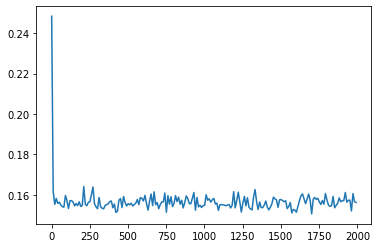

In [265]:
scores_smape = dict()

for iteration in range(1, 2000, 10):
    regr = SGDRegressor(max_iter=iteration, penalty='l1', alpha=1e-15)
    regr.fit(X_train, y_train.ravel())
    scores_smape[iteration] = smape(y_test.ravel(), regr.predict(X_test))

sns.lineplot(x=scores_smape.keys(), y=scores_smape.values())

<AxesSubplot:>

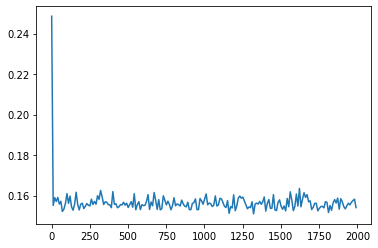

In [266]:
scores_smape = dict()

for iteration in range(1, 2000, 10):
    regr = SGDRegressor(max_iter=iteration, penalty='l2', alpha=0.0001)
    regr.fit(X_train, y_train.ravel())
    scores_smape[iteration] = smape(y_test.ravel(), regr.predict(X_test))

sns.lineplot(x=scores_smape.keys(), y=scores_smape.values())


<AxesSubplot:>

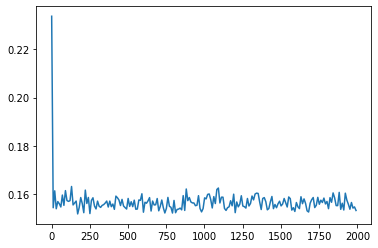

In [267]:
scores_smape = dict()

for iteration in range(1, 2000, 10):
    regr = SGDRegressor(max_iter=iteration, penalty='elasticnet', alpha=1e-15)
    regr.fit(X_train, y_train.ravel())
    scores_smape[iteration] = smape(y_test.ravel(), regr.predict(X_test))

sns.lineplot(x=scores_smape.keys(), y=scores_smape.values())